# Project 2 - Investigate a dataset: No-show appointments in Brazil

## Table of Contents
<ul>
<li><a href="#Our-data">Our data</a></li>
<li><a href="#Cleaning-the-data">Cleaning the data</a></li>
<li><a href="#Exploring-data-and-visualising">Exploring data and visualising</a></li>
<li><a href="#Observations">Observations</a></li>
</ul>

In [323]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt
%matplotlib inline

df = pd.read_csv("data.csv")

### Our data

Below are a few lines of code to explore the dataset. The dataset contains more than 110.000 rows of data describing hospital appointments in Brazil. Each row of data is characterised by a patient ID and an appointment ID (which form a composite key), as well as information on the patient (gender, age, health) and the appointment itself (attended or not, location, sheduling date and appointment date).

From there, we can try to answer some questions about the dataset:
* How many appointments (in percentage) are missed in average each year?
* How are missed appointments distributed by neighbourhood?
* Are men or women more likely to miss an appointment?
* How do health-related issues impact the incidence of no-show appointments?
* Are people with lower social welfare more likely to miss appointments?
* Does getting a SMS increase attendance to appointments?
* Is the amount of time between planning the appointment and the appointment itself impact the risk of no-show?

In [324]:
df.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No


In [325]:
df.shape

(110527, 14)

In [326]:
df.dtypes

PatientId         float64
AppointmentID       int64
Gender             object
ScheduledDay       object
AppointmentDay     object
Age                 int64
Neighbourhood      object
Scholarship         int64
Hipertension        int64
Diabetes            int64
Alcoholism          int64
Handcap             int64
SMS_received        int64
No-show            object
dtype: object

In [327]:
df.describe()

,PatientId,AppointmentID,Age,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received
count,1.105270e+05,1.105270e+05,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000
mean,1.474963e+14,5.675305e+06,37.088874,0.098266,0.197246,0.071865,0.030400,0.022248,0.321026
std,2.560949e+14,7.129575e+04,23.110205,0.297675,0.397921,0.258265,0.171686,0.161543,0.466873
min,3.921784e+04,5.030230e+06,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.172614e+12,5.640286e+06,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.173184e+13,5.680573e+06,37.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,9.439172e+13,5.725524e+06,55.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,9.999816e+14,5.790484e+06,115.000000,1.000000,1.000000,1.000000,1.000000,4.000000,1.000000


### Cleaning the data

Before we can dive deeper, the dataset needs some cleaning:
* Some datatypes are not adequate
* A few column names have typos
* Some values are out of range (age below 0, handicap different than 0 or 1*)
* Evt. remove duplicates

\* it is unclear whether other handicap values have a significance so the data points will be dropped altogether

In [328]:
# column names as lowercase
df.rename(columns=lambda x: x.lower(), inplace=True)

In [329]:
# changing patient ID to int
df.patientid = df.patientid.astype("int64")

In [330]:
# changing scheduledday and appointmentday to datatime and only keeping the date part
df.scheduledday=df.scheduledday.apply(lambda x: x[:10])
df.scheduledday=pd.to_datetime(df.scheduledday)

df.appointmentday=df.appointmentday.apply(lambda x: x[:10])
df.appointmentday=pd.to_datetime(df.appointmentday)

In [331]:
# renaming columns
df.rename(columns={"hipertension": "hypertension", "handcap": "handicap"}, inplace=True)

In [332]:
# invalid age values
df[df.age<0]

,patientid,appointmentid,gender,scheduledday,appointmentday,age,neighbourhood,scholarship,hypertension,diabetes,alcoholism,handicap,sms_received,no-show
99832,465943158731293,5775010,F,2016-06-06,2016-06-06,-1,ROMÃO,0,0,0,0,0,0,No


-1 is an invalid age but instead of dropping the row altogether, we will replace it by the mean value of the rest of the age data.

In [333]:
mean_age = df[df.age>=0]["age"].mean()
df.age=df.age.replace(-1,mean_age)

In [334]:
df.age=df.age.astype("int64")

In [335]:
#invalid handicap values
df[df.handicap>1]["handicap"].size

199

The invalid handicap values represent 199 data points, i.e. 0.2% of the total data. This should have minimal impact on the analysis.

In [336]:
df = df.loc[df.handicap<=1]

In [337]:
# search for duplicates and drop them
sum(df.duplicated())

0

In [338]:
# resulting clean dataset
df.dtypes

patientid                  int64
appointmentid              int64
gender                    object
scheduledday      datetime64[ns]
appointmentday    datetime64[ns]
age                        int64
neighbourhood             object
scholarship                int64
hypertension               int64
diabetes                   int64
alcoholism                 int64
handicap                   int64
sms_received               int64
no-show                   object
dtype: object

In [339]:
df.describe()

,patientid,appointmentid,age,scholarship,hypertension,diabetes,alcoholism,handicap,sms_received
count,1.103280e+05,1.103280e+05,110328.000000,110328.000000,110328.000000,110328.000000,110328.000000,110328.000000,110328.000000
mean,1.475273e+14,5.675299e+06,37.070753,0.098280,0.196831,0.071605,0.030382,0.018508,0.321179
std,2.561394e+14,7.129914e+04,23.097947,0.297694,0.397606,0.257833,0.171637,0.134781,0.466931
min,3.921700e+04,5.030230e+06,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.174654e+12,5.640278e+06,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.175389e+13,5.680568e+06,37.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,9.439381e+13,5.725510e+06,55.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,9.999816e+14,5.790484e+06,115.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Exploring data and visualising

#### How many appointments were missed during the analysed time period? (in percentage)

In [340]:
df.appointmentday.min()

Timestamp('2016-04-29 00:00:00')

In [341]:
df.appointmentday.max()

Timestamp('2016-06-08 00:00:00')

In [342]:
no_show = df[df["no-show"]=="Yes"]
no_show.shape

(22278, 14)

In [380]:
no_show_rate=100*len(no_show.index)/len(df.index)
show_rate=100-no_show_rate
no_show_rate

20.19251685882097

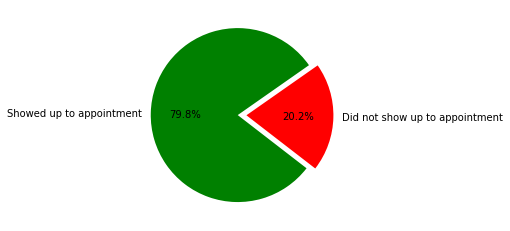

In [394]:
plt.pie([show_rate,no_show_rate], explode=[0,0.1], labels=["Showed up to appointment", "Did not show up to appointment"], autopct="%.1f%%", colors=["green","red"], startangle=35);

22278 appointments were missed between April 29 and June 8, 2016, i.e. approximately 20%. This is 1 out of 5 appointments, which is significant.

#### How are missed appointments distributed by neighbourhood?

In [344]:
# how many neighbourhoods?
df["neighbourhood"].nunique()

81

Given the large number of different neighbourhoods, we can concentrate on finding the top 10 neighbourhoods with highest number of no-shows per total scheduled appointments.

In [345]:
# no-shows by neighbourhood
no_show_neigh = no_show["neighbourhood"].value_counts()

In [346]:
# total number of appointments by neighbourhood
appoint_neigh = df["neighbourhood"].value_counts()

In [347]:
# proportion of no-shows per neighbourhood
no_show_prop_neigh=no_show_neigh.divide(appoint_neigh)
no_show_prop_neigh

AEROPORTO              0.125000
ANDORINHAS             0.230599
ANTÔNIO HONÓRIO        0.184502
ARIOVALDO FAVALESSA    0.219858
BARRO VERMELHO         0.215130
                         ...   
SÃO JOSÉ               0.215915
SÃO PEDRO              0.210440
TABUAZEIRO             0.183243
UNIVERSITÁRIO          0.210526
VILA RUBIM             0.166470
Name: neighbourhood, Length: 81, dtype: float64

In [395]:
# finding empty values
no_show_prop_neigh[no_show_prop_neigh.isna()]

Series([], Name: neighbourhood, dtype: float64)

In [349]:
no_show_prop_neigh["PARQUE INDUSTRIAL"]=0

In [350]:
no_show_prop_neigh = no_show_prop_neigh.sort_values(ascending=False)

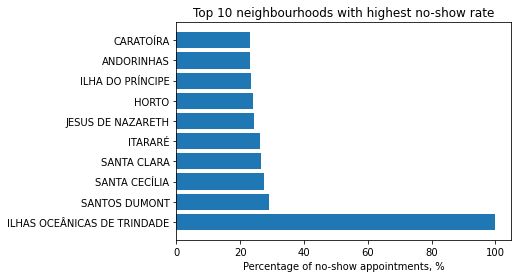

In [399]:
plt.barh(no_show_prop_neigh.index[:10],100*no_show_prop_neigh[:10])
plt.plot()
plt.xlabel("Percentage of no-show appointments, %")
plt.title("Top 10 neighbourhoods with highest no-show rate");

The graph shows the 10 hospitals with highest proportion of no-shows per appointment. ILHAS OCEANICAS DE TRINIDADE has a 100% no-show rate, but this is to consider with a grain of salt since there are only two appointments in that neighbourhood in the dataset. Note: generally these proportions do not tell the whole story since the number of samples per neighbourhood vary greatly.

#### Are men or women more likely to miss an appointment?

In [352]:
no_show_gender=no_show.gender.value_counts()

In [353]:
df_gender=df.gender.value_counts()

In [354]:
no_show_gender/df_gender

F    0.203092
M    0.199756
Name: gender, dtype: float64

There seems to be no significant difference between men and women for missed appointments.

#### How do health-related issues impact the incidence of no-show appointments?

In [405]:
def propVarDataframe(df,col):
    return 100*len(df[df[col]==1].index)/len(df.index)

In [406]:
# proportion of health issues in no-show population
no_health_issue_noshow = 100*len(no_show[(no_show.handicap==0) & (no_show.diabetes==0) & (no_show.hypertension==0) & (no_show.alcoholism==0)])/len(no_show.index)
handicap_noshow = propVarDataframe(no_show,"handicap")
diabetes_noshow = propVarDataframe(no_show,"diabetes")
hypertension_noshow = propVarDataframe(no_show,"hypertension")
alcoholism_noshow = propVarDataframe(no_show,"alcoholism")

In [407]:
# proportion of health issues in general population
no_health_issue_general = 100*len(df[(df.handicap==0) & (df.diabetes==0) & (df.hypertension==0) & (df.alcoholism==0)])/len(df.index)
handicap_general = propVarDataframe(df,"handicap")
diabetes_general = propVarDataframe(df,"diabetes")
hypertension_general = propVarDataframe(no_show,"hypertension")
alcoholism_general = propVarDataframe(no_show,"alcoholism")

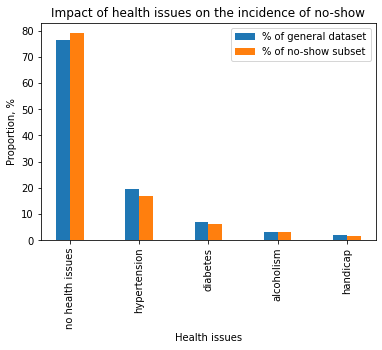

In [374]:
labels = ["no health issues","hypertension","diabetes","alcoholism","handicap"]
x = np.arange(len(labels))
width = 0.2
plt.bar(x-width/2,[no_health_issue_general,hypertension_general,diabetes_general,alcoholism_general,handicap_general],width=width,tick_label=labels,label="% of general dataset")
plt.bar(x,[no_health_issue_noshow,hypertension_noshow,diabetes_noshow,alcoholism_noshow,handicap_noshow],width=width,tick_label=labels,align="edge", label="% of no-show subset")
plt.xticks(rotation=90)
plt.xlabel("Health issues")
plt.ylabel("Proportion, %")
plt.title("Impact of health issues on the incidence of no-show")
plt.legend();

It looks like people with no health-related issues are in fact slightly over-represented in the no-show subset compared to the general dataset. Note that the proportions add up to more than 1 (100%) because some people have more than one health issue.

#### Are people with lower social welfare more likely to miss appointments?

In [411]:
def comparePropDataframes(no_show,df,col):
    no_var=100*len(no_show[no_show[col]==0].index)/len(df[df[col]==0].index)
    yes_var=100*len(no_show[no_show[col]==1].index)/len(df[df[col]==1].index)
    return (no_var, yes_var)

In [412]:
# calculating proportion of no-shows in the population receiving financial aid and the population not receiving it
no_scholarship_noshow, scholarship_noshow = comparePropDataframes(no_show,df,"scholarship")
scholarship_noshow

23.76648529004888

In [413]:
no_scholarship_noshow

19.8029853746796

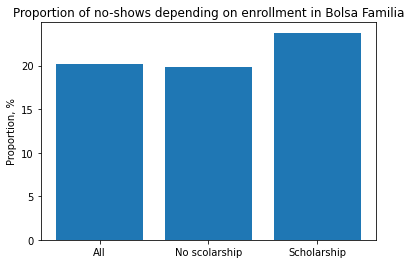

In [414]:
plt.bar(["All", "No scolarship", "Scholarship"],[no_show_rate,no_scholarship_noshow,scholarship_noshow])
plt.title("Proportion of no-shows depending on enrollment in Bolsa Familia")
plt.ylabel("Proportion, %");

It would appear that people with lower social welfare, enrolled in Bolsa Familia, have a higher tendency (23,8 %) to miss appointments compared to the entire dataset (20,2 %) and compared to people not enrolled (19.8 %).

#### Does getting a SMS increase attendance to appointments?

In [415]:
no_sms_noshow, sms_noshow = comparePropDataframes(no_show,df,"sms_received")

In [416]:
sms_noshow

27.58572033300409

In [417]:
no_sms_noshow

16.694484130693123

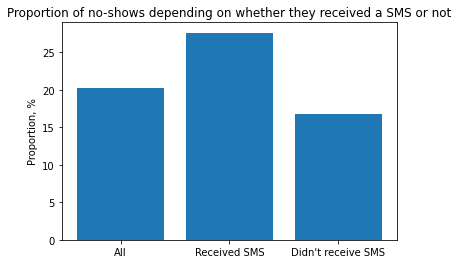

In [418]:
plt.bar(["All", "Received SMS", "Didn't receive SMS"],[no_show_rate,sms_noshow,no_sms_noshow])
plt.title("Proportion of no-shows depending on whether they received a SMS or not")
plt.ylabel("Proportion, %");

Surprisingly, the data would suggest that getting a SMS increases the chance for a person to not show up to their appointment. Of all people getting a SMS, nearly 28% do not show up to their appointment, 8 points above the rate in the entire data population, against 17% for all people not getting a SMS. It is odd that getting an SMS (reminder? confirmation of scheduling?) would negatively affect the attendance to appointments. I would expect neutral or positive effect. It is difficult to explain this result especially when little is know about the SMS system. 

#### Is the amount of time between planning the appointment and the appointment itself impact the risk of no-show?

In [363]:
# creating a new column, weeks_between, based on the dates in the dataframe
df['weeks_between'] = (df['appointmentday'] - df['scheduledday']).dt.days//7

In [364]:
df['weeks_between']

0         0
1         0
2         0
3         0
4         0
         ..
110522    5
110523    5
110524    5
110525    5
110526    5
Name: weeks_between, Length: 110328, dtype: int64

In [365]:
# updating no_show dataframe
no_show = df[df["no-show"]=="Yes"]

In [366]:
noshow_weeks_rate = no_show["weeks_between"].value_counts()/df["weeks_between"].value_counts()

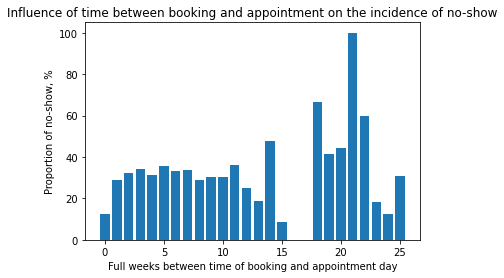

In [378]:
plt.bar(noshow_weeks_rate.index[1:],100*noshow_weeks_rate[1:])
plt.xlabel("Full weeks between time of booking and appointment day")
plt.ylabel("Proportion of no-show, %")
plt.title("Influence of time between booking and appointment on the incidence of no-show");

Though it is not possible to make a definite conclusion based solely on this graph, it does appear that the more days between the booting time and the appointment itself, the higher the chance for no-show.

Note: a data error was noticed, where some data points show the booking date after the appointment date. These were not shown on the graph.

### Observations

Although this analysis does not make use of inferential statistics and is as such tentative, it draws our attention to several factors worth looking more into when trying to increase appointments attendance:
* Individuals enrolled in Bolsa Familia, i.e. with lower social welfare, are more likely by 5 points to miss a booked appointment.
* The more time pass between the booking and the actual appointment date, the higher risk for no-show.
* Surprisingly, the influence of sending SMS to the patients seems to negatively impact attendance to appointments. This seems very counterintuitive and calls for checking if the data is accurate in this respect. Other data analysts/scientists have questioned this on Kaggle.